In [1]:
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML
from pysit.util.util import *
from cycler import cycler
import h5py

Limited tf.compat.v2.summary API due to missing TensorBoard installation
Limited tf.summary API due to missing TensorBoard installation


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import copy as copy
import math
import os
import scipy.io as sio
from scipy.signal import hilbert
from shutil import copy2

import sys

from pysit import *
from pysit.gallery import horizontal_reflector
from pysit.gallery.layered_medium import three_layered_medium
from pysit.util.io import *
from pysit.util.compute_tools import *

from pysit.util.parallel import *

from mpi4py import MPI
from FTools.compute_adjoint_source import *
from FTools.compute_IC import *
from FTools.fang_plot import *


In [4]:
def creat_model(n, c_w, n_conv, vb, vp):
    s1 = (n[0]-c_w[0])//2
    s2 = (n[1]-c_w[1])//2
    A = np.ones(n)*vb
    A[s1:n[0]-s1,s2:n[1]-s2] = vp
    S = opSmooth2D(n, n_conv, window_len=[5, 5])
    B = S * A.flatten()
    B = B.reshape(n)

    return B

In [5]:
def create_ini_model(v_slow):
    n_org = (201, 101)
    c_w = [141,71]
    n_conv = (100,100)
    vb = 2.0
    v_true = 2.5
    v_fast = 3.0


    o_org = np.array([0.0,0.0])
    d_org = np.array([0.04, 0.04]);
    model_size_phy_org = np.array([8.0, 4.0])
    n_org = np.floor(model_size_phy_org/d_org)
    n_org = n_org.astype(int) + 1
    output = odn2grid(o_org, d_org, n_org)
    Depth = output[0]
    Lateral = output[1]

    vi = creat_model(n_org, c_w, n_conv, vb, v_slow)
    
    return vi

In [6]:
def plot_models2(Vels, Titles, cmap='jet'):
    n_v = len(Vels)
    n_col = 2
    n_row = n_v // n_col
    
    fig,ax = plt.subplots(n_row,n_col,figsize=(20,4*n_row))
    k = 0
    v_out = []
    for i in range(0,2):
        for j in range(0,n_row):
            vi = Vels[k]
            om = [0.0, 0.0]
            dm = [0.01, 0.01]
            nm = np.shape(vi)
            output = odn2grid(om, dm, nm)
            Depth = output[0]
            Lateral = output[1]
            clim_v = [1.5,5.5]
            plot_model(fig, ax[j][i], vi, Lateral, Depth, nm, clim=clim_v, title_str=Titles[k], cmap=cmap)
            k += 1
            
    return fig
    
        
    

In [7]:
def plot_trace(Vels, Legends, trace):
    fig = plt.figure()
    om = [0.0, 0.0]
    dm = [0.01, 0.01]
    nm = np.shape(Vels[0])
    output = odn2grid(om, dm, nm)
    Depth = output[0]
    Lateral = output[1] 
    for i in range(len(Legends)):
        vi = Vels[i]
        plt.plot(Depth, vi[:,trace])
        plt.title('x = ' + str(dm[0]*(trace-1)) +' km' )
        
    plt.legend(Legends)
    
    return fig
        
        

In [8]:
def Compute_wavefields(ExpDir, idx):
    o_org = np.array([0.0,0.0])
    d_org = np.array([0.02, 0.02]);
    model_size_phy_org = np.array([6.0, 3.0])
    n_org = np.floor(model_size_phy_org/d_org)
    n_org = n_org.astype(int) + 1
    vel_true = 2.5
    output = odn2grid(o_org, d_org, n_org)
    Depth = output[0]
    Lateral = output[1]
    vt = np.ones(n_org) * vel_true
    vt = vt.transpose()
    vt = np.reshape(vt, (np.prod(n_org), 1))

    pmlx = PML(0.5, 100)
    pmlz = PML(0.5, 100)

    x_config = (0.0, model_size_phy_org[1], pmlx, pmlx)
    z_config = (0.0, model_size_phy_org[0], pmlz, pmlz)

    d = RectangularDomain(x_config, z_config)
    m = CartesianMesh(d, n_org[1], n_org[0])
    
    C, C0, m, d = horizontal_reflector(m)

    C.data = vt

    model_size = m._shapes[False,True]
    model_delta = m.deltas

    # xrec_multiple = np.array(range(10, model_size[0]-10)) * model_delta[0]
    # xsrc_multiple = np.linspace(xrec_multiple[0], xrec_multiple[-1], num=10)
    xsrc_multiple = [1.5]
    xrec_multiple = [1.5]
    print(xsrc_multiple)
    zsrc_multiple = 0.5
    zrec_multiple = 5.5
    shots = equispaced_acquisition_given_locations(m,
                                                   RickerWavelet(8.0),
                                                   sources_x_locations=xsrc_multiple,
                                                   source_depth=zsrc_multiple,
                                                   source_kwargs={},
                                                   receivers_x_locations=xrec_multiple,
                                                   receiver_depth=zrec_multiple
                                                   )

    
    # Define and configure the wave solver
    trange = (0.0,4.0)
                                   
    solver = ConstantDensityAcousticWave(m,
                                         spatial_accuracy_order=4,
                                         trange=trange,
                                         kernel_implementation='cpp',
                                         max_C=3.2)

    solver.max_C = 3.2
                                   
    # Generate synthetic Seismic data
    tt = time.time()
    base_model = solver.ModelParameters(m,{'C': C})
    print('strat generate data')

    generate_seismic_data(shots, solver, base_model)
                                   
    print('Data generation: {0}s'.format(time.time()-tt))
    
    Dobs = shots[0].receivers.data
    Dpred = []
    
    for i in idx:
        print(i)
        fname = ExpDir + '/x_' + str(i) + '.mat'
        data = sio.loadmat(fname)['data']
        C.data = data
        base_model = solver.ModelParameters(m,{'C': C})
        generate_seismic_data(shots, solver, base_model)
        Dpred.append(shots[0].receivers.data)
        
    
    return Dobs, Dpred
        
        
        
    

In [9]:
def create_animation_single(vt, fwave, Lateral, Depth, model_size, ntime, climc=None, ksmp=50):
    plt.figure()
    fig, ax = plt.subplots(1,2,figsize=(12,6))

    ims = []
    model_sizet = model_size
    model_sizec = [model_size[1], model_size[0]]
    DD = np.zeros(model_sizet)
    EE = np.zeros(model_sizet)
    vt = np.reshape(vt, model_size)
#     vt = np.transpose(vt)
    for i in range(0,ntime,ksmp):    
        A = np.reshape(fwave[i], model_sizec)
        A = np.transpose(A)
        
        ax[0].set_title('Final model')
        ax[0].set_xlabel('X [km]')
        ax[0].set_ylabel('Z [km]')
        im0=ax[0].imshow(vt, clim=climc[0], 
                            extent=[Lateral[0], Lateral[model_size[1]-1], Depth[model_size[0]-1], Depth[0]],
                            animated=True)   
        im0.set_cmap('jet')
        
        ax[1].set_title('Final wavefield')
        ax[1].set_xlabel('X [km]')
        ax[1].set_ylabel('Z [km]')
        im2=ax[1].imshow(A,clim=climc[1], 
                            extent=[Lateral[0], Lateral[model_size[1]-1], Depth[model_size[0]-1], Depth[0]],
                            animated=True)
        im2.set_cmap('jet')
        
        
        ims.append([im0,im2])

    ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True, repeat_delay=1000)
    plt.close()
    
    return ani

In [10]:
def create_animation_model_update(Dirs, Titles, ntime=100, ksmp=1):
    plt.figure()
    ncol = 2
    nrow = len(Dirs) // 2
    climc = [1.5,5.5]
    fig, ax = plt.subplots(nrow, ncol, figsize=(12,6*nrow))
    Lateral = [0.0, 4.6]
    Depth = [0.0, 1.5]

    ims = []
#     vt = np.transpose(vt)
    for i in range(0,ntime,ksmp):    
        
        fname = Dirs[0] + '/x_'+str(i)+'.mat'
        data = sio.loadmat(fname)['data']
        vi0  = np.reshape(data,(563,251))
        vi0  = vi0.transpose()
        vi0  = vi0[50:201, 50:513]
        
        
        ax[0].set_title(Titles[0])
        ax[0].set_xlabel('X [km]')
        ax[0].set_ylabel('Z [km]')
        im0=ax[0].imshow(vi0, clim=climc, 
                            extent=[Lateral[0], Lateral[-1], Depth[-1], Depth[0]],
                            animated=True)   
        im0.set_cmap('jet')
        
        fname = Dirs[1] + '/x_'+str(i)+'.mat'
        data = sio.loadmat(fname)['data']
        vi1  = np.reshape(data,(563,251))
        vi1  = vi1.transpose()
        vi1  = vi1[50:201, 50:513]
        
        ax[1].set_title(Titles[1])
        ax[1].set_xlabel('X [km]')
        ax[1].set_ylabel('Z [km]')
        im2=ax[1].imshow(vi1,clim=climc, 
                            extent=[Lateral[0], Lateral[-1], Depth[-1], Depth[0]],
                            animated=True)
        im2.set_cmap('jet')
        
        
        ims.append([im0,im2])

    ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True, repeat_delay=1000)
    plt.close()
    
    return ani

In [11]:
def create_animation_model_transmission(Vels, Titles, frametitle=None,  ksmp=1):
    plt.figure()
    ncol = 3
    nrow = 2
    climc = [2.0,3.0]
    fig, ax = plt.subplots(nrow, ncol, figsize=(18,8))
    Lateral = [0.0, 8.0]
    Depth = [0.0, 4.0]
    nm = np.shape(Vels[0][0])

    ims = []
#     vt = np.transpose(vt)
    for i in range(0,len(Vels),ksmp):  
#     for i in range(0,1,ksmp):  
        k = 0
        im = []
        for j in range(0, ncol):
            for l in range(0, nrow):
                imk = plot_model(fig, ax[l][j], Vels[i][k], Lateral, Depth, nm, clim=climc, title_str=Titles[k],animated=True)
                im.append(imk)
                k+=1
        
        mt = fig.text(0.5, 0.5, frametitle[i], fontsize=15)
        im.append(mt)
        ims.append(im)

    ani = animation.ArtistAnimation(fig, ims, interval=500, blit=False, repeat_delay=1000)
    plt.close()
    
    return ani

In [12]:
def Create_Waves(ExpDir, idx):
    o_org = np.array([0.0,0.0])
    d_org = np.array([0.02, 0.02]);
    model_size_phy_org = np.array([6.0, 3.0])
    n_org = np.floor(model_size_phy_org/d_org)
    n_org = n_org.astype(int) + 1
    vel_true = 2.5
    output = odn2grid(o_org, d_org, n_org)
    Depth = output[0]
    Lateral = output[1]

    pmlx = PML(0.5, 100)
    pmlz = PML(0.5, 100)

    x_config = (0.0, model_size_phy_org[1], pmlx, pmlx)
    z_config = (0.0, model_size_phy_org[0], pmlz, pmlz)

    d = RectangularDomain(x_config, z_config)
    m = CartesianMesh(d, n_org[1], n_org[0])
    
    C, C0, m, d = horizontal_reflector(m)

    model_size = m._shapes[False,True]
    model_delta = m.deltas

    xsrc_multiple = [1.5]
    xrec_multiple = [1.5]
    print(xsrc_multiple)
    zsrc_multiple = 0.5
    zrec_multiple = 5.5
    shots = equispaced_acquisition_given_locations(m,
                                                   RickerWavelet(8.0),
                                                   sources_x_locations=xsrc_multiple,
                                                   source_depth=zsrc_multiple,
                                                   source_kwargs={},
                                                   receivers_x_locations=xrec_multiple,
                                                   receiver_depth=zrec_multiple
                                                   )

    
    # Define and configure the wave solver
    trange = (0.0,4.0)
                                   
    solver = ConstantDensityAcousticWave(m,
                                         spatial_accuracy_order=4,
                                         trange=trange,
                                         kernel_implementation='cpp',
                                         max_C=3.2)

    solver.max_C = 3.2
                                   

    fname = ExpDir + '/x_' + str(idx) + '.mat'
    data = sio.loadmat(fname)['data']
    C.data = data
    wavefields=[]
    base_model = solver.ModelParameters(m,{'C': C})
    generate_seismic_data(shots, solver, base_model, wavefields=wavefields)
    
    v_final = np.reshape(data, model_size)
    v_final = np.transpose(v_final)
    v_true = np.ones(np.shape(v_final))
    
    
    return v_true, v_final, wavefields, Lateral, Depth, n_org, m
    
    

In [13]:
def plot_model_data(Dobs,Dpred,idx,ExpDir,clim=[2.0,3.0]):
    o_org = np.array([0.0,0.0])
    d_org = np.array([0.02, 0.02]);
    model_size_phy_org = np.array([6.0, 3.0])
    n_org = np.floor(model_size_phy_org/d_org)
    n_org = n_org.astype(int) + 1
    vel_true = 2.5
    output = odn2grid(o_org, d_org, n_org)
    Depth = output[0]
    Lateral = output[1]
    vt = np.ones(n_org) * vel_true
    
    n_row = 1 + len(Dpred)
    n_col = 4
    
    t_smp = np.linspace(0.0,4.0,len(Dobs))
    plt.figure()
    fig,ax = plt.subplots(n_row,n_col,figsize=(20,5*n_row))
    plot_model(fig, ax[0][0], vt, Lateral, Depth, n_org, clim=clim, title_str='True')
    plot_data(ax[0][1], Dobs, t_smp, title_str='Dobs')
    
    for i_row in range(1,n_row):
        i = idx[i_row-1]
        fname = ExpDir + '/x_' + str(i) + '.mat'
        data = sio.loadmat(fname)['data']
        vi   = np.reshape(data, [n_org[1], n_org[0]])
        vi   = np.transpose(vi)
        plot_model(fig, ax[i_row][0], vi, Lateral, Depth, n_org, clim=clim, title_str='x_'+str(i))
        plot_data(ax[i_row][1], Dpred[i_row-1], t_smp, title_str='Dpred_'+str(i))
        plot_data(ax[i_row][2], Dpred[i_row-1]-Dobs, t_smp, title_str='Dpred_'+str(i)+' - Dobs')
        plot_data(ax[i_row][3], Dpred[i_row-1], t_smp)
        plot_data(ax[i_row][3], Dobs, t_smp)
        ax[i_row][3].legend(['Dpred','Dobs'])
        
        
def plot_model_data_misfit(ExpDir):
    M_error = np.zeros(31)
    for i in range(0,31):
        fname = ExpDir + '/x_' + str(i) + '.mat'
        data = sio.loadmat(fname)['data']
        M_error[i] = np.linalg.norm(data-2.5)
        
    fname = ExpDir + '/objective_value_ot_l.mat'
    data, o, d, n = read_data(fname)
    fig,ax = plt.subplots(1,2,figsize=(14,5))
    ax[0].plot(np.array(range(0,31)), M_error)
    ax[0].set_title('Model_error')
    ax[0].set_xlabel('Iteration')
    
    ax[1].plot(np.array(range(0,30)), data.flatten())
    ax[1].set_title('Objective')
    ax[1].set_xlabel('Iteration')
    
    
        
        
        
    
    
    

In [14]:
def plot_models(DirSub, Titles):
    n_v = len(DirSub)
    n_col = 2
    n_row = n_v // n_col
    
    fig,ax = plt.subplots(n_row,n_col,figsize=(20,4*n_row))
    k = 0
    v_out = []
    for i in range(0,2):
        for j in range(0,n_row):
            fname = DirSub[k]+'/result.mat'
            vi, om, dm, nm = read_data(fname)
            output = odn2grid(om, dm, nm)
            Depth = output[0]
            Lateral = output[1]
            clim_v = [1.5,5.5]
            plot_model(fig, ax[j][i], vi, Lateral, Depth, nm, clim=clim_v, title_str=Titles[k])
            k += 1
            v_out.append(vi)
    
    return v_out

def plot_models_EI(DirSub, Titles):
    n_v = len(DirSub)
    n_col = 2
    n_row = n_v // n_col
    
    fig,ax = plt.subplots(n_row,n_col,figsize=(20,4*n_row))
    k = 0
    v_out = []
    for i in range(0,2):
        for j in range(0,n_row):
            fname = DirSub[k]+'/result_EI.mat'
            A = sio.loadmat(fname)
            vi = A['data']
            om = [0.0,0.0]
            dm = [0.01,0.01]
            nm = np.shape(vi)
#             vi, om, dm, nm = read_data(fname)
            output = odn2grid(om, dm, nm)
            Depth = output[0]
            Lateral = output[1]
            clim_v = [1.5,5.5]
            plot_model(fig, ax[j][i], vi, Lateral, Depth, nm, clim=clim_v, title_str=Titles[k])
            k += 1
            v_out.append(vi)
    
    return v_out
    

In [15]:
def plot_model_error(DirSub, Legends):
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    MEF=[]
    for i in range(len(LSDirSub)):
        fname = DirSub[i] + '/model_error.mat'
        ME, o, d, n = read_data(fname)
        ME = ME.flatten()
        ax[0].plot(ME)
        MEF.append(ME[-1])
        
    ax[0].legend(Legends)
    ax[0].set_title('Relative model errors')
    ax[0].set_xlabel('Iteration')
    ax[1].plot([2,3,4,5],MEF)
    ax[1].set_xlabel('Cutting frequency [Hz]')
    ax[1].set_title('Relative model error v.s. cutting frequency')
    
    return MEF
        
        

In [16]:
def savefig2(name):
    plt.savefig(name + '.pdf',bbox_inches='tight')
    plt.savefig(name + '.eps',bbox_inches='tight')
    plt.savefig(name + '.png',bbox_inches='tight')

In [17]:
def savefig(name):
    plt.savefig(name + '.pdf')
    plt.savefig(name + '.eps')
    plt.savefig(name + '.png')

In [18]:
if __name__ == '__main__':
    RootDir = '/wavedata/Zhilong/ExxonProject/ConstantModel/ExxonMeeting20190314'
    FigDir = '/math/home/fangzl/Project/Figure/ExxonProject/Paper/Journal/Transmission'
    

## 1. Initial model

In this example, we compare the performances of different algorithms with respect to the change of the initial model.


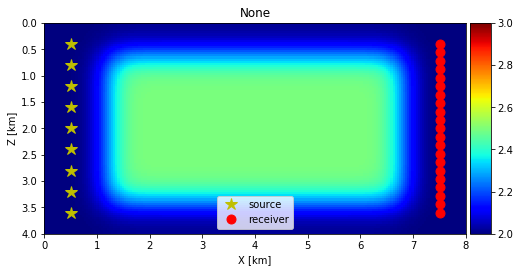

In [46]:
    ExpDir = '/wavedata/Zhilong/ExxonProject/ConstantModel/ExxonMeeting20190314/OneEvent_PGD'
    FigDir1 = './IMMError'
    SubDir1 = []
    VelInd  = []
    for i in range(27):
        SubDir1.append(str(i+20))
        VelInd.append(i+20)
    
    for i in range(25):
        SubDir1.append(str(i+54))
        VelInd.append(i+54)
        
    VelInd = np.array(VelInd)
    
    
    SubDir2 = ['LS', 'EIP1', 'CC', 'OT_L', 'OT_E', 'OT_Q']
    Labels2 = ['LS', 'ei', 'correlate', 'ot_l', 'ot_e', 'ot_q']
    
    Files = []
    for i in range(len(Labels2)):
        Files.append('v_' + Labels2[i] + '.mat')
        
    vtfile = '/wavedata/Zhilong/ExxonProject/ConstantModel/ExxonMeeting20190314/OneEvent_SF_PGD_Ormsby/Exp1_7/CC/true.mat'
    vt, ot, dt, nt = read_data(vtfile)
    nm = [nt[1], nt[0]]
    om = ot
    dm = dt
    vt = np.reshape(vt,nm)
    
    output = odn2grid(om, dm, nm)
    Depth = output[0]
    Lateral = output[1]
    clim_v = [2.0,3.0]
    
    fig,ax = plt.subplots(1,1,figsize=(8,4))
    plot_model(fig, ax, vt, Lateral, Depth, nm, clim=clim_v, title_str=None)
    srcz = np.linspace(0.4, 3.6, 9)
    srcx = np.ones(9) * 0.5
    ax.plot(srcx, srcz, 'y*', markersize=13, label='source')
    recx = np.ones(21) * 7.5
    recz = np.linspace(0.4, 3.6, 21)
    ax.plot(recx, recz, 'ro', markersize=9, label='receiver')
    ax.legend()
#     savefig(FigDir1 + '/vtrue')

In [22]:
    model_error = np.zeros((len(SubDir1), len(SubDir2)))
    model_error_f = np.zeros((len(SubDir1), len(SubDir2)))
    Vels = []
    Vels_f = []
    ERRORS = dict()
    for i in range(len(SubDir2)):
        ERRORS[SubDir2[i]] = []
        
    for i in range(len(SubDir1)):
        Velsi = []
        Velsi_f = []
        for j in range(len(SubDir2)):
            vij_file = ExpDir + '/Exp2_' + SubDir1[i] + '/' + SubDir2[j] + '/v_' + Labels2[j] + '.mat'
            vij, otmp, dtmp, ntmp = read_data(vij_file)
            model_error_f[i][j] = np.linalg.norm(vij.transpose().flatten() - vt.flatten())/ np.linalg.norm(vt.flatten())
            Velsi_f.append(vij.transpose())
            
            
            Error = 1e10
            opt_k = 0
            Errors = np.ones(101)
            for k in range(101):
                vijk_file = ExpDir + '/Exp2_' + SubDir1[i] + '/' + SubDir2[j] + '/x_' + str(k) + '.mat'
                A = sio.loadmat(vijk_file)
                vijk = A['data']
                Errori = np.linalg.norm(vijk.flatten() - vt.flatten())
                Errors[k] = Errori
                if Errori < Error:
                    Error = Errori
                    vij = vijk
                    opt_k = k
            write_data(ExpDir + '/Exp2_' + SubDir1[i] + '/' + SubDir2[j] + '/model_error.mat',Errors, 0,1,len(Errors))
            ERRORS[SubDir2[j]].append(Errors)
                
                    
            print(opt_k,end=",  ")
#             vij, otmp, dtmp, ntmp = read_data(vij_file)
            vij = vij.transpose()
            model_error[i][j] = np.linalg.norm(vij.transpose().flatten() - vt.flatten()) / np.linalg.norm(vt.flatten())
            Velsi.append(vij.transpose())
        Vels.append(Velsi)
        Vels_f.append(Velsi_f)
  

14,  100,  100,  10,  12,  100,  14,  100,  100,  10,  10,  100,  13,  100,  100,  9,  8,  100,  12,  100,  100,  8,  6,  100,  12,  100,  100,  7,  5,  100,  11,  100,  100,  6,  3,  100,  10,  100,  100,  4,  1,  100,  10,  100,  100,  3,  0,  100,  9,  100,  100,  0,  0,  100,  8,  100,  100,  0,  0,  100,  7,  100,  100,  0,  0,  100,  5,  100,  100,  0,  0,  100,  2,  100,  100,  0,  0,  100,  0,  100,  99,  0,  0,  100,  0,  100,  84,  0,  0,  100,  0,  100,  71,  100,  0,  100,  0,  100,  60,  100,  100,  100,  0,  100,  48,  100,  100,  100,  0,  100,  39,  100,  100,  100,  0,  100,  33,  100,  100,  100,  0,  100,  26,  100,  100,  100,  100,  100,  8,  100,  100,  100,  100,  100,  8,  100,  100,  100,  100,  100,  8,  100,  100,  100,  100,  100,  8,  99,  100,  100,  100,  100,  7,  100,  100,  100,  100,  100,  7,  100,  100,  100,  100,  100,  7,  100,  100,  100,  99,  100,  8,  100,  100,  100,  100,  100,  9,  100,  100,  100,  100,  100,  11,  100,  100,  100,  100, 

In [51]:
print(len(ERRORS[SubDir2[0]]))

52


#### Here we plot the iteration history of each experiment

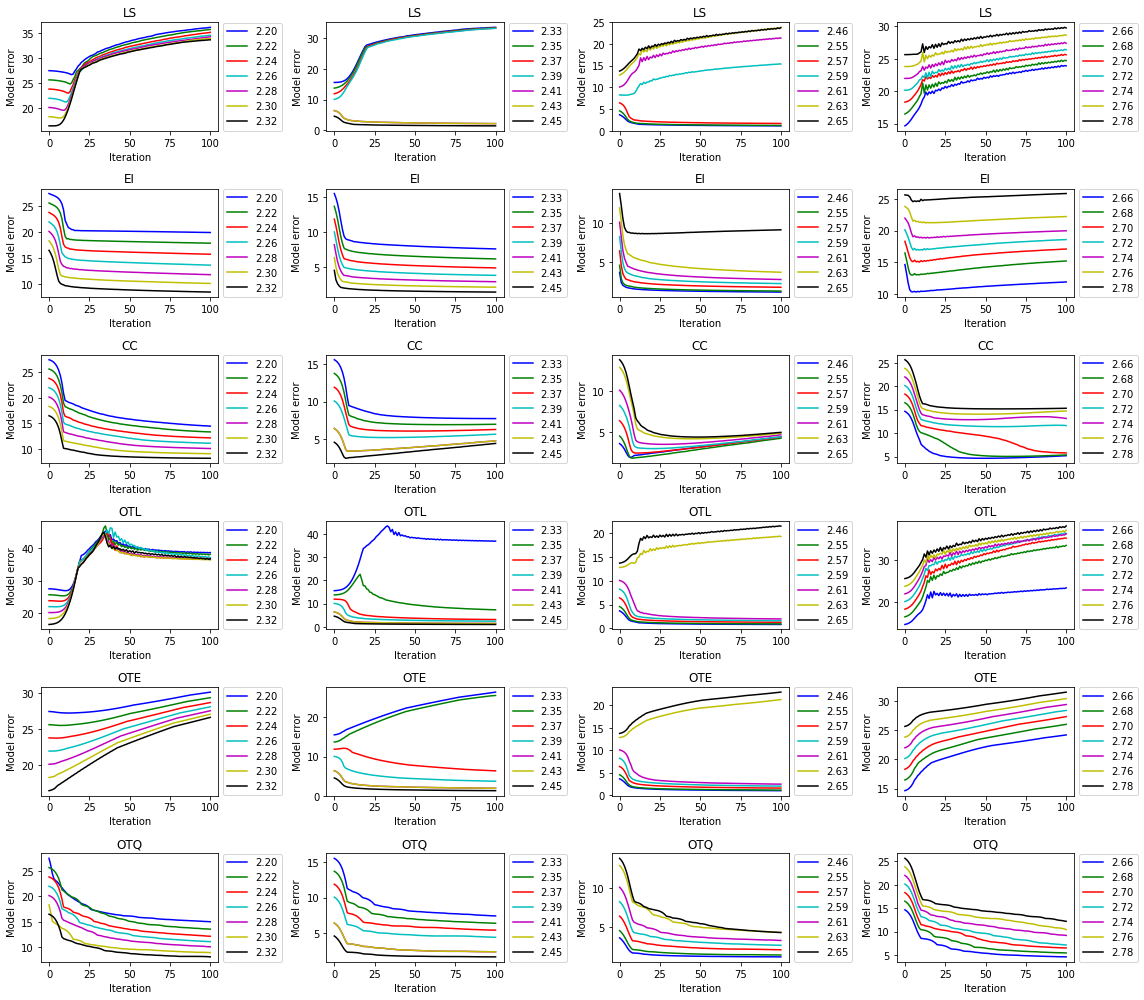

In [69]:
fig,ax = plt.subplots(6,4,figsize=[16,14])
SubDir2tmp = ['LS', 'EI', 'CC', 'OTL', 'OTE', 'OTQ']
colortmp = ['b','g','r','c','m','y','k']

for k in range(len(SubDir2)):
    for j in range(4):
        for i in range(j*13,(j+1)*13,2):
            strtmp = '2.'+str(SubDir1[i])
            ax[k][j].plot(ERRORS[SubDir2[k]][i],label=strtmp,color=colortmp[(i%13)//2])
            ax[k][j].set_title(SubDir2tmp[k])
            ax[k][j].set_xlabel('Iteration')
            ax[k][j].set_ylabel('Model error')
            ax[k][j].legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# savefig(FigDir1 + '/ModelErrorIter')

In [49]:
    model_error_ini = np.zeros(len(SubDir1))
    Vels_ini = []
    for i in range(len(SubDir1)):
        j = 0
        
        vijk_file = ExpDir + '/Exp2_' + SubDir1[i] + '/' + SubDir2[j] + '/x_0.mat'
        A = sio.loadmat(vijk_file)
        vijk = A['data']
        Errori = np.linalg.norm(vijk.flatten() - vt.flatten())
        vij = vijk            
        vij = vij.transpose()
        model_error_ini[i] = np.linalg.norm(vij.transpose().flatten() - vt.flatten()) / np.linalg.norm(vt.flatten())
        Vels_ini.append(vij.transpose())

    model_error_ini = np.insert(model_error_ini, 13, 0.0)
  

In [76]:
  
    x_im = []
    for i in range(27):
        x_im.append(2.0+(i+20.0)/100.0)
    
    x_im.append(2.5)
    
    for i in range(25):
        x_im.append(2.0+(i+54.0)/100.0)
        
    clrs_list=['k','g','m','r','b','c'] # list of basic colors
    styl_list=['-','--','-.',':',':', ':'] # list of basic linestyles
    
#     plt.figure()
#     for i in range(len(SubDir2)):
#         clrr=clrs_list[i]
#         styl=styl_list[i]
        
#         mei = model_error[:,i]
# #         mei = np.append(mei,0.0)
#         mei = np.insert(mei, 27, 0.0)
#         plt.plot(x_im,mei,color=clrr,ls=styl)
        
#     plt.legend(SubDir2)
#     plt.xlabel(r'$v_{box}$ [km/s]')
#     plt.ylabel(r'Relative model error $\frac{\|\mathbf{m}_{t}-\mathbf{m}_{f}\|_2}{\|\mathbf{m}_{t}\|_2}$')
#     savefig(FigDir1 + '/ModelError2')

In [77]:
model_error_ini2 = np.zeros(len(x_im))
Vels_ini2 = []
for i in range(len(x_im)):
    vi_i = create_ini_model(x_im[i])
    model_error_ini2[i] = np.linalg.norm(vi_i.transpose().flatten() - vt.flatten()) / np.linalg.norm(vt.flatten())
    Vels_ini2.append(vi_i.transpose())

In [78]:
np.max(Vels_ini2[0].flatten())

2.1999999219106443

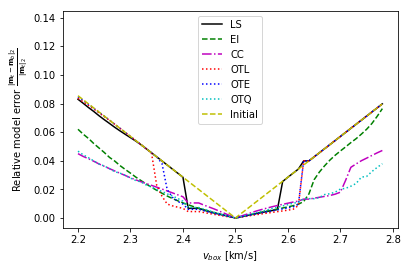

In [79]:
    plt.figure()
#     ['LS', 'EI', 'CC', 'OTL', 'OTE', 'OTQ']
    Legend_STR = ['LS', 'EI', 'CC', 'OTL', 'OTE', 'OTQ', 'Initial']
    for i in range(len(SubDir2)):
        clrr=clrs_list[i]
        styl=styl_list[i]
        
        mei = model_error[:,i]
#         mei = np.append(mei,0.0)
        mei = np.insert(mei, 27, 0.0)
        plt.plot(x_im,mei,color=clrr,ls=styl)

    plt.ylim([-0.007,0.145])
    plt.xlabel(r'$v_{box}$ [km/s]')
    plt.ylabel(r'Relative model error $\frac{\|\mathbf{m}_{t}-\mathbf{m}_{b}\|_2}{\|\mathbf{m}_{t}\|_2}$')
    plt.plot(x_im, model_error_ini2,color='y',ls='--')
    plt.legend(Legend_STR)
#     savefig(FigDir1 + '/ModelError2')

In [80]:
#     Legend_STR2 = ['CC', 'EI', 'LS', 'OTE', 'OTL', 'OTQ']
    Legend_STR2 = ['LS', 'EI', 'CC', 'OTL', 'OTE', 'OTQ', 'Initial']
    plt.figure()
    for i in range(len(SubDir2)):
        clrr=clrs_list[i]
        styl=styl_list[i]
        
        mei = model_error_f[:,i]
#         mei = np.append(mei,0.0)
        mei = np.insert(mei, 27, 0.0)
        plt.plot(x_im,mei,color=clrr,ls=styl)
    
    plt.ylim([-0.007,0.145])
    plt.xlabel(r'$v_{box}$ [km/s]')
    plt.ylabel(r'Relative model error $\frac{\|\mathbf{m}_{t}-\mathbf{m}_{f}\|_2}{\|\mathbf{m}_{t}\|_2}$')
    plt.plot(x_im, model_error_ini2,color='y',ls='--')
    plt.legend(Legend_STR2)
#     savefig(FigDir1 + '/ModelError')

In [ ]:
Ftitle = []
climc = [2.0,3.0]

Lateral = [0.0, 8.0]
Depth = [0.0, 4.0]
FrameValue = [20, 34, 40, 60, 63, 78]
for i in range(0,len(FrameValue)):
    Ftitle.append(r'$v_{box}$ = 2.' + str(FrameValue[i]) + ' km/s')
print(Ftitle)

fig, ax = plt.subplots(6,1,figsize=[6,30])
for i in range(len(FrameValue)):
    FrameIndex = np.where(VelInd==FrameValue[i])[0][0]
#     imk = plot_model(fig, ax[i], Vels_ini[FrameIndex], Lateral, Depth, nm, clim=climc, title_str=Ftitle[i])
    im1=ax[i].imshow(Vels_ini[FrameIndex], extent=[Lateral[0], Lateral[-1], Depth[-1], Depth[0]], clim=clim_v, interpolation='nearest', aspect='auto', cmap='jet')
#     im1=ax[i].imshow(Vels[FrameIndex], extent=[Lateral[0], Lateral[-1], Depth[-1], Depth[0]], clim=clim_v, interpolation='nearest', aspect='auto', cmap='jet')
    ax[i].set_title(Ftitle[i])
    ax[i].set_xlabel('X [km]')
    ax[i].set_ylabel('Z [km]')
    fig.colorbar(im1, ax=ax[i])
# savefig2(FigDir1 + '/ModelsCmpIni')
plt.close()

for j in range(len(SubDir2)):
    fig, ax = plt.subplots(6,1,figsize=[6,32])
    for i in range(len(FrameValue)):
        FrameIndex = np.where(VelInd==FrameValue[i])[0][0]
#         veli = Vels_f[FrameIndex][j]
        veli = Vels[FrameIndex][j]
        veli = np.reshape(veli,[101,201])
    #     imk = plot_model(fig, ax[i], Vels_ini[FrameIndex], Lateral, Depth, nm, clim=climc, title_str=Ftitle[i])
        im1=ax[i].imshow(veli, extent=[Lateral[0], Lateral[-1], Depth[-1], Depth[0]], clim=clim_v, interpolation='nearest', aspect='auto', cmap='jet')
        ax[i].set_title(Ftitle[i])
        ax[i].set_xlabel('X [km]')
        ax[i].set_ylabel('Z [km]')
#     savefig2(FigDir1 + '/ModelsCmp'+SubDir2[j])
#     plt.close()


# FrameValue = [20, 34, 40, 60, 63, 78]

# for i in range(len(FrameValue)):
#     FrameIndex = np.where(VelInd==FrameValue[i])
#     plt.figure()
#     ncol = 3
#     nrow = 2
#     climc = [2.0,3.0]
#     fig, ax = plt.subplots(nrow, ncol, figsize=(18,8))
#     Lateral = [0.0, 8.0]
#     Depth = [0.0, 4.0]
#     nm = np.shape(Vels[0][0])
    
#     k = 0
#     for j in range(0, ncol):
#         for l in range(0, nrow):
#             imk = plot_model(fig, ax[l][j], Vels[FrameIndex[0][0]][k], Lateral, Depth, nm, clim=climc, title_str=SubDir2[k])
#             k+=1
            
#     savefig(FigDir1 + '/ModelsCmp' + str(FrameValue[i]))

In [90]:
Ftitle = []
climc = [2.0,3.0]

Lateral = [0.0, 8.0]
Depth = [0.0, 4.0]
FrameValue = [20, 34, 40, 60, 63, 78]
for i in range(0,len(FrameValue)):
    Ftitle.append(r'$v_{box}$ = 2.' + str(FrameValue[i]) + ' km/s')
print(Ftitle)

fig, ax = plt.subplots(6,1,figsize=[6,30])
for i in range(len(FrameValue)):
    FrameIndex = np.where(VelInd==FrameValue[i])[0][0]
#     imk = plot_model(fig, ax[i], Vels_ini[FrameIndex], Lateral, Depth, nm, clim=climc, title_str=Ftitle[i])
    im1=ax[i].imshow(Vels_ini[FrameIndex], extent=[Lateral[0], Lateral[-1], Depth[-1], Depth[0]], clim=clim_v, interpolation='nearest', aspect='auto', cmap='jet')
#     im1=ax[i].imshow(Vels[FrameIndex], extent=[Lateral[0], Lateral[-1], Depth[-1], Depth[0]], clim=clim_v, interpolation='nearest', aspect='auto', cmap='jet')
    ax[i].set_title(Ftitle[i])
    ax[i].set_xlabel('X [km]')
    ax[i].set_ylabel('Z [km]')
    fig.colorbar(im1, ax=ax[i])
# savefig2(FigDir1 + '/ModelsCmpIni')
plt.close()


for j in range(len(SubDir2)):
    fig, ax = plt.subplots(6,1,figsize=[6,32])
    for i in range(len(FrameValue)):
        FrameIndex = np.where(VelInd==FrameValue[i])[0][0]
#         veli = Vels_f[FrameIndex][j]
        veli = Vels_f[FrameIndex][j]
        Errors_tmp = ERRORS[SubDir2[j]][FrameIndex]
        veli = np.reshape(veli,[101,201])
    #     imk = plot_model(fig, ax[i], Vels_ini[FrameIndex], Lateral, Depth, nm, clim=climc, title_str=Ftitle[i])
        im1=ax[i].imshow(veli, extent=[Lateral[0], Lateral[-1], Depth[-1], Depth[0]], clim=clim_v, interpolation='nearest', aspect='auto', cmap='jet')
        ax[i].set_title(Ftitle[i])
        ax[i].set_xlabel('X [km]')
        ax[i].set_ylabel('Z [km]')
        if Errors_tmp[60:80].mean() > Errors_tmp[80:100].mean():
            ax[i].scatter(0.5,0.25,s=400,marker='*',color='green')
        else:
            ax[i].scatter(0.5,0.25,s=400,marker='*',color='yellow')
#     savefig2(FigDir1 + '/ModelsCmp'+SubDir2[j]+'fm')
    plt.close()


# FrameValue = [20, 34, 40, 60, 63, 78]

# for i in range(len(FrameValue)):
#     FrameIndex = np.where(VelInd==FrameValue[i])
#     plt.figure()
#     ncol = 3
#     nrow = 2
#     climc = [2.0,3.0]
#     fig, ax = plt.subplots(nrow, ncol, figsize=(18,8))
#     Lateral = [0.0, 8.0]
#     Depth = [0.0, 4.0]
#     nm = np.shape(Vels[0][0])
    
#     k = 0
#     for j in range(0, ncol):
#         for l in range(0, nrow):
#             imk = plot_model(fig, ax[l][j], Vels[FrameIndex[0][0]][k], Lateral, Depth, nm, clim=climc, title_str=SubDir2[k])
#             k+=1
            
#     savefig(FigDir1 + '/ModelsCmp' + str(FrameValue[i]))

['$v_{box}$ = 2.20 km/s', '$v_{box}$ = 2.34 km/s', '$v_{box}$ = 2.40 km/s', '$v_{box}$ = 2.60 km/s', '$v_{box}$ = 2.63 km/s', '$v_{box}$ = 2.78 km/s']
